# <font color = limegreen size = 7>**Introduction**</font>

Analysis was performed on the cancer dataset using dimension reduction and clustering. The data contains 569 observations, 30 variables describing cancer cells, a variable with cancer ID and a variable with cancer type (B - benign cancer, M - malignant cancer).<br>
The purpose of the analysis is to detect groups of cancer and compare them to groups by type of cancer. We want to answer the following questions:
* Do the symptoms of cancer differ significantly by type? And is it possible to observe the exact boundary between such symptoms?
* Will the groups created by clustering be similar to the groups by cancer type? If not, what will cause the differences?



In [78]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)

In [79]:
data_whole = pd.read_csv('Cancer_Data.csv')
data_whole.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [80]:
data_whole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [81]:
# data for analysis without ID variable and empty column
data = data_whole.iloc[:,1:-1]
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Almost all methods used are sensitive to outliers. Therefore, all rows with outliers have been removed. Otherwise, the performed analyzes will be inaccurate.

In [82]:
# determining the outliers
data_bool = pd.DataFrame()
data_bool['diagnosis'] = np.ones(len(data['diagnosis'])).astype(bool)
for var in data.columns[1:]:
    q1 = np.quantile(data[var], 0.25)
    q3 = np.quantile(data[var], 0.75)
    iqr = q3-q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    data_bool[var] = (data[var]>=lower) & (data[var]<=upper)
data_bool.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,True,True,True,True,True,True,False,False,True,True,...,True,True,True,False,True,False,True,True,False,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,False,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,False,False,True,True,False,...,True,True,True,True,False,False,True,True,False,False
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [83]:
# deleting the outliers
data = data[data_bool]
data.dropna(inplace=True)
data = data.reset_index(drop=True)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,18.25,19.98,119.6,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368
1,M,13.71,20.83,90.2,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510
2,M,16.02,23.24,102.7,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,...,19.19,33.88,123.8,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
3,M,15.78,17.89,103.6,781.0,0.09710,0.12920,0.09954,0.06606,0.1842,...,20.42,27.28,136.5,1299.0,0.1396,0.5609,0.3965,0.18100,0.3792,0.10480
4,M,15.85,23.95,103.7,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,...,16.84,27.66,112.0,876.5,0.1131,0.1924,0.2322,0.11190,0.2809,0.06287


In [84]:
# normalization of numeriacal data
std_scaler = StandardScaler() 

data_std = pd.DataFrame(std_scaler.fit_transform(data.iloc[:,1:]),
                               columns=data.columns[1:])

data_std.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.964461,0.377377,1.973596,2.108920,0.112751,0.650915,1.066356,1.488638,0.277054,-0.756789,...,2.413510,0.521788,2.468580,2.665355,0.767070,0.428375,1.121869,1.941020,0.625692,0.333092
1,0.134540,0.594978,0.225722,0.033027,2.126689,2.239566,0.677832,0.935739,2.210386,2.655183,...,0.610898,0.607065,0.541116,0.511879,1.815139,1.456575,0.369659,1.187592,0.931552,2.854076
2,1.065623,1.211941,0.968866,1.020884,-0.930314,-0.560180,-0.560181,-0.104415,-1.002217,-0.846630,...,1.270617,1.626840,1.138359,1.280326,-0.523241,-0.524523,-0.459405,0.068471,0.361226,0.400490
3,0.968887,-0.157666,1.022372,0.945414,0.317713,1.229127,0.797817,1.178389,0.507899,-0.077988,...,1.651581,0.454277,1.712978,1.732891,0.539659,3.248023,1.244971,1.696556,2.302172,2.027655
4,0.997102,1.393701,1.028317,0.953051,-0.768502,0.399021,0.794553,0.693088,0.531946,-1.563363,...,0.542758,0.521788,0.604460,0.449613,-0.770426,-0.177761,0.127537,0.311933,0.041568,-1.336598


# <font color = limegreen size = 7>**Dimensionality reduction**</font>

**Dimensions were reduced using two methods:**<br>
* Principal component analysis (PCA), where on the basis of the values of the principal components, using the Kaiser criterion, the criterion of explained variance and the scree criterion, it was indicated to how many dimensions the data set can be reduced to. In addition, 2D and 3D visualizations were made to observe possible patterns;
* The t-SNE algorithm, with which it was possible to visualize a multidimensional set in two dimensions, so that it could be observed. are there any data schemas.

## <font color = lightgreen size = 6>**Principal component analysis (PCA)**</font>

In [85]:
# execution of the algorithm
pca = PCA()
results_pca = pca.fit_transform(data_std)

# showing the results
results_pca

array([[ 5.92706678,  3.50541662, -1.26276358, ...,  0.06492658,
        -0.05011013, -0.0045537 ],
       [ 5.15701236, -4.1752157 ,  0.29262111, ..., -0.05466994,
        -0.01267958,  0.00785229],
       [ 1.17301257,  3.40849842,  0.41472935, ...,  0.00794234,
        -0.02577122,  0.01116705],
       ...,
       [ 2.23911035, -0.64447037,  0.9557649 , ...,  0.00144736,
        -0.00730296, -0.01835975],
       [ 1.29473532, -0.71517166,  2.68651625, ..., -0.07399943,
         0.00011699, -0.00462713],
       [ 4.57337938,  1.86874951,  2.30417484, ..., -0.0132109 ,
        -0.0058055 , -0.00821574]])

### <font color = limegreen size = 5>**Number of components to reduction**</font>

In [86]:
# the Kaiser criterion
pca.explained_variance_

array([12.7908425 ,  5.62500833,  3.01890278,  1.9214634 ,  1.89952947,
        1.21387209,  0.81614997,  0.53129627,  0.46539921,  0.34270283,
        0.31595302,  0.28163686,  0.23507829,  0.18050819,  0.10723001,
        0.07353766,  0.04672928,  0.04125745,  0.03525827,  0.02873282,
        0.02321002,  0.02089795,  0.01603542,  0.01355706,  0.01228102,
        0.00891167,  0.00733304,  0.00157693,  0.00057793,  0.00009703])

The Kaiser rule is to drop all components with eigenvalues under 1. By this criterion only first 6 components are important.

In [87]:
# part of explained variance
pca.explained_variance_ratio_

array([0.42529016, 0.18702917, 0.10037725, 0.06388785, 0.06315856,
       0.04036074, 0.02713664, 0.01766538, 0.01547433, 0.01139473,
       0.01050531, 0.00936431, 0.00781625, 0.00600182, 0.00356535,
       0.0024451 , 0.00155373, 0.00137179, 0.00117232, 0.00095535,
       0.00077172, 0.00069485, 0.00053317, 0.00045077, 0.00040834,
       0.00029631, 0.00024382, 0.00005243, 0.00001922, 0.00000323])

In [88]:
# the criterion of explained variance
for p in range(1, len(pca.explained_variance_ratio_) + 1):
    print(f'{p} components explain {sum(pca.explained_variance_ratio_[:p])*100:.2f} % of variance')

1 components explain 42.53 % of variance
2 components explain 61.23 % of variance
3 components explain 71.27 % of variance
4 components explain 77.66 % of variance
5 components explain 83.97 % of variance
6 components explain 88.01 % of variance
7 components explain 90.72 % of variance
8 components explain 92.49 % of variance
9 components explain 94.04 % of variance
10 components explain 95.18 % of variance
11 components explain 96.23 % of variance
12 components explain 97.16 % of variance
13 components explain 97.95 % of variance
14 components explain 98.55 % of variance
15 components explain 98.90 % of variance
16 components explain 99.15 % of variance
17 components explain 99.30 % of variance
18 components explain 99.44 % of variance
19 components explain 99.56 % of variance
20 components explain 99.65 % of variance
21 components explain 99.73 % of variance
22 components explain 99.80 % of variance
23 components explain 99.85 % of variance
24 components explain 99.90 % of variance
2

The criterion of explained variance is to leave only those components that explain the necessary part of the variance. Usually it is 70-80%, while for medical data it is better to assume a level above 90%. By this criterion at least 7 components are important.

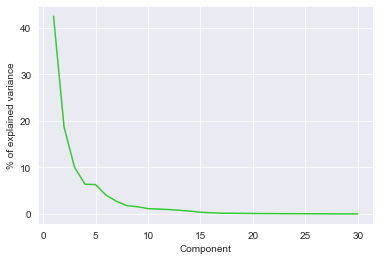

In [89]:
# scree criterion
sns.set_style("darkgrid")

plt.plot(range(1, results_pca.shape[1]+1),
         pca.explained_variance_ratio_*100, 'limegreen')
plt.xlabel('Component')
plt.ylabel('% of explained variance')
plt.show()

The scree plot criterion looks for the “elbow” in the curve and selects all components just before the line flattens out. In our case these are first 6-7 components.

### <font color = limegreen size = 5>**Visualization**</font>

In [90]:
# data preparation
components = pd.DataFrame(results_pca,
                          columns = [f'Component {i}' for i in range(1,results_pca.shape[1]+1)])
components['diagnosis'] = data['diagnosis']
components.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 22,Component 23,Component 24,Component 25,Component 26,Component 27,Component 28,Component 29,Component 30,diagnosis
0,5.927067,3.505417,-1.262764,-0.918328,-0.253334,-0.212554,-0.537035,0.289970,-0.166103,-0.063746,...,-0.014686,-0.222694,0.041779,0.214154,-0.081863,0.040782,0.064927,-0.050110,-0.004554,M
1,5.157012,-4.175216,0.292621,-1.952160,-0.483912,-0.974573,-2.663737,-0.756233,0.267848,1.077529,...,-0.152571,-0.030799,-0.131085,0.134995,0.054910,-0.036600,-0.054670,-0.012680,0.007852,M
2,1.173013,3.408498,0.414729,0.264824,-1.803123,0.116081,-1.676595,0.308689,-0.787821,-0.138644,...,0.109958,0.011393,-0.077886,0.010442,-0.099065,-0.018862,0.007942,-0.025771,0.011167,M
3,6.369327,-0.739285,-0.732368,-0.143661,0.210606,1.658567,-1.718025,1.021147,0.201568,-0.475332,...,0.305253,-0.057280,0.207793,-0.166150,0.155543,-0.090123,-0.067795,-0.044224,-0.007087,M
4,2.786797,0.666649,3.394382,0.267920,1.023933,1.203931,2.657474,1.050990,-0.367212,0.048985,...,0.198818,0.142794,-0.003534,-0.062332,0.014324,0.049774,0.056183,-0.003227,-0.020165,M


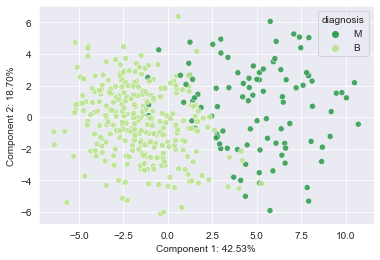

In [91]:
# visualization 2D
sns.scatterplot(x='Component 1', y='Component 2', data=components, 
                hue='diagnosis', 
                palette = 'YlGn_r',
                alpha=0.9)
plt.xlabel('Component 1: 42.53%')
plt.ylabel('Component 2: 18.70%')
plt.show()

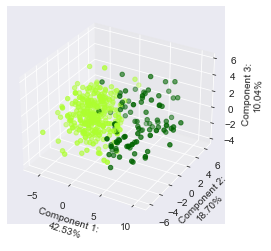

In [92]:
# visualization 3D
ax = plt.axes(projection='3d')
ax.scatter3D(components.loc[:,'Component 1'], components.loc[:,'Component 2'],
             components.loc[:,'Component 3'],
             c = components['diagnosis'].replace({'B':'greenyellow','M':'darkgreen'}))
ax.set_xlabel('Component 1:\n42.53%')
ax.set_ylabel('Component 2:\n18.70%')
ax.set_zlabel('Component 3:\n10.04%')
plt.show()


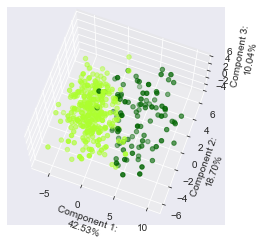

In [93]:
# visualization 3D
ax = plt.axes(projection='3d')
ax.scatter3D(components.loc[:,'Component 1'], components.loc[:,'Component 2'],
             components.loc[:,'Component 3'],
             c = components['diagnosis'].replace({'B':'greenyellow','M':'darkgreen'}))
ax.set_xlabel('Component 1:\n42.53%')
ax.set_ylabel('Component 2:\n18.70%')
ax.set_zlabel('Component 3:\n10.04%')
ax.view_init(elev=70, azim=-70)
plt.show()

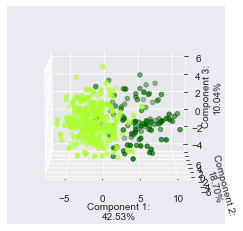

In [94]:
# visualization 3D
ax = plt.axes(projection='3d')
ax.scatter3D(components.loc[:,'Component 1'], components.loc[:,'Component 2'],
             components.loc[:,'Component 3'],
             c = components['diagnosis'].replace({'B':'greenyellow','M':'darkgreen'}))
ax.set_xlabel('Component 1:\n42.53%')
ax.set_ylabel('Component 2:\n18.70%')
ax.set_zlabel('Component 3:\n10.04%')
ax.view_init(elev=10, azim=-90)
plt.show()

## <font color = lightgreen size = 6>**t-SNE algorithm**</font>

### <font color = limegreen size = 5>**perplexity = 50**</font>

In [95]:
# execution of the algorithm
tsne = TSNE(perplexity=50)
results_sne = tsne.fit_transform(data_std)

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [96]:
# data preparation
coordinates = pd.DataFrame(results_sne,
                          columns = [f'Coordinate {i}' for i in range(1,results_sne.shape[1]+1)])
coordinates['diagnosis'] = data['diagnosis']
coordinates.head()

,Coordinate 1,Coordinate 2,diagnosis
0,8.114551,9.864863,M
1,2.354086,10.716929,M
2,6.828883,2.005126,M
3,4.869523,10.081964,M
4,4.643703,4.360543,M


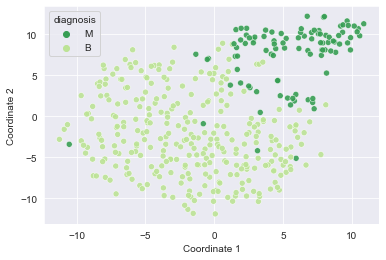

In [97]:
# visualization
sns.scatterplot(x='Coordinate 1', y='Coordinate 2', data=coordinates, 
                hue='diagnosis',
                palette = 'YlGn_r',
                alpha=0.9)
plt.show()

### <font color = limegreen size = 5>**perplexity = 5**</font>

In [98]:
# execution of the algorithm
tsne = TSNE(perplexity=5)
results_sne2 = tsne.fit_transform(data_std)

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [99]:
# data preparation
coordinates = pd.DataFrame(results_sne2,
                          columns = [f'Coordinate_{i}' for i in range(1,results_sne2.shape[1]+1)])
coordinates['diagnosis'] = data['diagnosis']
coordinates.head()

,Coordinate_1,Coordinate_2,diagnosis
0,-12.822249,-70.694542,M
1,-13.988359,-44.988544,M
2,21.553976,-36.347141,M
3,-26.256414,-45.423473,M
4,6.510678,-43.384998,M


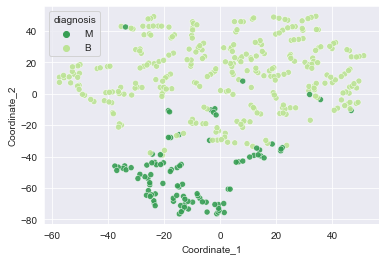

In [100]:
# visualization
sns.scatterplot(x='Coordinate_1', y='Coordinate_2', data=coordinates, 
                hue='diagnosis',
                palette = 'YlGn_r',
                alpha=0.9)
plt.show()

## <font color = lightgreen size = 6>**Dimensions reduction conclusion**</font>

Due to the large number of variables, only 7 components will be used for clustering. In this way, we avoid the curse of dimensionality, which makes the analysis inaccurate for a large number of dimensions (variables). <br>
In addition, the visualizations revealed that there is no clear line between the symptoms of two types of cancer. This means that there are observations with very similar symptoms, but a different type of cancer. In the graphs, we can see that case of malignant cancer having similar symptoms to benign cancer is quite common.

# <font color = limegreen size = 7>**Clustering**</font>

**Cluster analysis was performed using two methods:**
* Hierarchical cluster analysis with the use of Ward's combining method, consisting in combining the most similar objects in successive steps by minimizing variance;
* K-means separating objects into a given number of groups, based on the distances between objects.

## <font color = lightgreen size = 6>**Hierarchical clustering**</font>

In [101]:
# execution of the algorithm
clust_res = linkage(components.iloc[:, :7], method='ward')

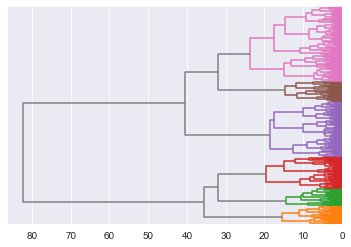

In [102]:
# dendrogram
dendrogram(clust_res,
           orientation='left',
           color_threshold=30,
           above_threshold_color='gray',
           no_labels=True)
plt.show()


The graph shows that the last two groups differ the most. However, in previous analysis we noticed that the differences between symptoms of the two types of cancer are not so clear. Therefore, more groups were made, splitting the dendrogram by distanse of 30.

In [103]:
# splitting into 6 groups
groups_hier = cut_tree(clust_res, n_clusters=6)

# adding column with group number
data_std['Groups_hier'] = groups_hier
data_std.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Groups_hier
0,1.964461,0.377377,1.973596,2.108920,0.112751,0.650915,1.066356,1.488638,0.277054,-0.756789,...,0.521788,2.468580,2.665355,0.767070,0.428375,1.121869,1.941020,0.625692,0.333092,0
1,0.134540,0.594978,0.225722,0.033027,2.126689,2.239566,0.677832,0.935739,2.210386,2.655183,...,0.607065,0.541116,0.511879,1.815139,1.456575,0.369659,1.187592,0.931552,2.854076,1
2,1.065623,1.211941,0.968866,1.020884,-0.930314,-0.560180,-0.560181,-0.104415,-1.002217,-0.846630,...,1.626840,1.138359,1.280326,-0.523241,-0.524523,-0.459405,0.068471,0.361226,0.400490,0
3,0.968887,-0.157666,1.022372,0.945414,0.317713,1.229127,0.797817,1.178389,0.507899,-0.077988,...,0.454277,1.712978,1.732891,0.539659,3.248023,1.244971,1.696556,2.302172,2.027655,1
4,0.997102,1.393701,1.028317,0.953051,-0.768502,0.399021,0.794553,0.693088,0.531946,-1.563363,...,0.521788,0.604460,0.449613,-0.770426,-0.177761,0.127537,0.311933,0.041568,-1.336598,0


<font color = limegreen size = 5>**Clustering result**</font>

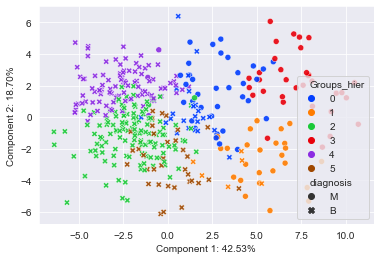

In [121]:
# adding column with group number
components['Groups_hier'] = groups_hier

# 2 components visualization
sns.scatterplot(x='Component 1', y='Component 2', data=components,
                hue='Groups_hier',
                style='diagnosis',
                palette='bright',
                alpha=0.9)
plt.xlabel('Component 1: 42.53%')
plt.ylabel('Component 2: 18.70%')
plt.show()

In [105]:
# adding column with group number
data['Groups_hier'] = groups_hier

# pivot table with groups by clustering and cancer type
data_pivot_hier = data.pivot_table(index='Groups_hier', columns='diagnosis', values='area_mean',
                 aggfunc=lambda x: len(x), margins=True)
data_pivot_hier.fillna(0, inplace=True)

# adding column with part of benign cancer in each group
data_pivot_hier['B_part'] = round(
    data_pivot_hier.loc[:, "B"]/data_pivot_hier.loc[:, "All"], 2)

# adding column with part of malignant cancer in each group
data_pivot_hier['M_part'] = round(
    data_pivot_hier.loc[:, "M"]/data_pivot_hier.loc[:, "All"], 2)

data_pivot_hier

diagnosis,B,M,All,B_part,M_part
Groups_hier,,,,,
0,24.0,34.0,58,0.41,0.59
1,6.0,26.0,32,0.19,0.81
2,135.0,2.0,137,0.99,0.01
3,0.0,33.0,33,0.00,1.00
4,99.0,3.0,102,0.97,0.03
5,36.0,0.0,36,1.00,0.00
All,300.0,98.0,398,0.75,0.25


The graph and the table show that most of created groups are able to clearly identify the types of cancer with an error of less than 5%. But we also can see that the first two groups are not so obvious and their symptoms can apply to both type of cancer.

In [106]:
# average values by groups
data_std_by_hier_group = data_std.groupby(
    'Groups_hier').mean(numeric_only=True)

data_std_by_hier_group

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
Groups_hier,,,,,,,,,,,,,,,,,,,,,
0,0.768536,0.222761,0.765388,0.720543,0.047626,0.321143,0.438002,0.554200,0.106158,-0.472704,...,0.774680,0.277872,0.789499,0.718701,0.125461,0.377376,0.549497,0.700320,0.221856,-0.013108
1,0.496292,0.327936,0.605747,0.400470,1.281895,1.929707,1.579725,1.562195,1.083060,1.238062,...,0.693460,0.486256,0.806270,0.585999,1.323702,1.962308,1.525328,1.610769,1.285202,1.780481
2,-0.718925,-0.218209,-0.716025,-0.687393,0.296187,-0.265634,-0.491075,-0.490316,0.170652,0.412809,...,-0.698856,-0.183877,-0.701464,-0.665187,0.284267,-0.332973,-0.433627,-0.442383,0.156603,0.017558
3,2.086236,0.893723,2.094842,2.270765,0.359757,1.000713,1.788012,1.883358,0.395391,-0.579223,...,2.175114,0.811376,2.145965,2.345882,0.553172,0.866046,1.382561,1.452464,0.365686,0.110938
4,-0.084914,-0.152420,-0.140989,-0.132725,-0.852020,-0.900529,-0.730167,-0.659902,-0.716253,-0.763698,...,-0.188349,-0.182238,-0.253752,-0.231324,-0.830488,-0.796482,-0.750185,-0.704139,-0.712959,-0.798843
5,-0.615230,-0.207373,-0.567494,-0.606414,-0.259071,0.412371,0.188736,-0.272260,-0.116239,0.784877,...,-0.665168,-0.407577,-0.567364,-0.642362,-0.614576,0.377704,0.267220,-0.212940,-0.410962,0.533345


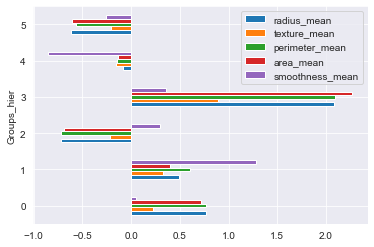

In [107]:
# average values of groups by the firts 5 variables
data_std_by_hier_group.iloc[:, :5].plot.barh()
plt.show()


The graph above shows characteristics of the created groups according to the firts 5 variables.

## <font color = lightgreen size = 6>**K-means clustering**</font>

<font color = limegreen size = 5>**Choice of the number of groups**</font>

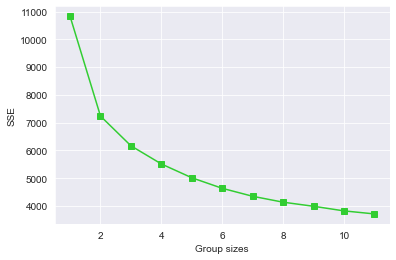

In [108]:
# Elbow method

# calculating the sum of the squares of the distances of the points from the centers of group for 12 ways of splitting
SSE = []
for k in range(1, 12):
    km = KMeans(n_clusters=k,
                init='random',
                random_state=0,
                n_init=30)
    km.fit(components.iloc[:, :7])
    SSE.append(km.inertia_)

# sum of squared error
plt.plot(range(1, 12), SSE,
         marker='s', c='limegreen')
plt.xlabel('Group sizes')
plt.ylabel('SSE')
plt.show()

The graph shows how sum of the squares of the distances of the points from the centers of the groups decreases as the number of groups increases. The sum of squared decreases significantly after splitting on 2, 3, 4 and 5 groups. 

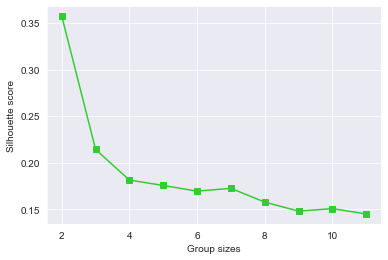

In [109]:
# silhouette method

# calculating the silhouette score for 12 ways of splitting
score = []
for k in range(2, 12):
    km = KMeans(n_clusters=k,
                 init='random',
                 random_state=0,
                 n_init=30)
    results_km = km.fit(components.iloc[:, :7])
    coefficient = silhouette_score(components.iloc[:, :7], results_km.labels_)
    score.append(coefficient)

# silhouette score values
plt.plot(range(2, 12), score,
         marker='s', c = 'limegreen')
plt.xlabel('Group sizes')
plt.ylabel('Silhouette score')
plt.show()


The chart shows how the average silhouette score changes as the number of groups increases. We can see that the biggest silhouette score is for spliting on 2 groups. But the same as for hierarchical clustering we want to create more groups. The chart shows that silhouette score increase slightly for 7 groups.

In [110]:
# silhouette coefficient
for i in range(2,8):
    kmeans = KMeans(n_clusters=i,
                        init='random',
                        random_state=0,
                        n_init=30)
    results = kmeans.fit(components.iloc[:, :7])
    score = silhouette_score(data_std.iloc[:, :-1], results.labels_)
    print(f'Silhouette coefficient for {i} groups: {score}')
print()

# Davies-Bouldin score
for i in range(2, 8):
    kmeans = KMeans(n_clusters=i,
                    init='random',
                    random_state=0,
                    n_init=30)
    results = kmeans.fit(components.iloc[:, :7])
    score = davies_bouldin_score(data_std.iloc[:, :-1], results.labels_)
    print(f'Davies-Bouldin score for {i} groups: {score}')
print()

# Calinski-Harabasz score
for i in range(2, 8):
    kmeans = KMeans(n_clusters=i,
                    init='random',
                    random_state=0,
                    n_init=30)
    results = kmeans.fit(components.iloc[:, :7])
    score = calinski_harabasz_score(data_std.iloc[:, :-1], results.labels_)
    print(
        f'Calinski-Harabasz score for {i} groups: {score}')

Silhouette coefficient for 2 groups: 0.33003687536221243
Silhouette coefficient for 3 groups: 0.19057904330886757
Silhouette coefficient for 4 groups: 0.15750455702509217
Silhouette coefficient for 5 groups: 0.14925595945160433
Silhouette coefficient for 6 groups: 0.1427092879757179
Silhouette coefficient for 7 groups: 0.14375239426682537

Davies-Bouldin score for 2 groups: 1.3010098683420221
Davies-Bouldin score for 3 groups: 1.791400434116249
Davies-Bouldin score for 4 groups: 1.8291540891207132
Davies-Bouldin score for 5 groups: 1.6997939064428451
Davies-Bouldin score for 6 groups: 1.7329378316810242
Davies-Bouldin score for 7 groups: 1.67870170175845

Calinski-Harabasz score for 2 groups: 170.76265175781418
Calinski-Harabasz score for 3 groups: 126.97033326397639
Calinski-Harabasz score for 4 groups: 106.11616319895995
Calinski-Harabasz score for 5 groups: 94.1211379120529
Calinski-Harabasz score for 6 groups: 85.43981982682274
Calinski-Harabasz score for 7 groups: 78.2884060547414

For all ways of clustering under 7 groups calculated silhouette coefficient, Davies-Bouldin score and Calinski-Harabasz score. The best number of group due to these scores:
* Silhouette coefficient: 3 groups
* Davies-Bouldin score: 7 groups
* Calinski-Harabasz score: 3 groups


The data was splitted on 3 groups.

In [111]:
# execution of the algorithm
kmeans_gr3 = KMeans(n_clusters=3,
                init='random',
                random_state=0,
                n_init=30)
results_gr3 = kmeans_gr3.fit(components.iloc[:, :7])

groups_kmeans = results_gr3.labels_

# adding column with group number
data_std['Groups_kmeans'] = groups_kmeans
data_std.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Groups_hier,Groups_kmeans
0,1.964461,0.377377,1.973596,2.108920,0.112751,0.650915,1.066356,1.488638,0.277054,-0.756789,...,2.468580,2.665355,0.767070,0.428375,1.121869,1.941020,0.625692,0.333092,0,0
1,0.134540,0.594978,0.225722,0.033027,2.126689,2.239566,0.677832,0.935739,2.210386,2.655183,...,0.541116,0.511879,1.815139,1.456575,0.369659,1.187592,0.931552,2.854076,1,0
2,1.065623,1.211941,0.968866,1.020884,-0.930314,-0.560180,-0.560181,-0.104415,-1.002217,-0.846630,...,1.138359,1.280326,-0.523241,-0.524523,-0.459405,0.068471,0.361226,0.400490,0,2
3,0.968887,-0.157666,1.022372,0.945414,0.317713,1.229127,0.797817,1.178389,0.507899,-0.077988,...,1.712978,1.732891,0.539659,3.248023,1.244971,1.696556,2.302172,2.027655,1,0
4,0.997102,1.393701,1.028317,0.953051,-0.768502,0.399021,0.794553,0.693088,0.531946,-1.563363,...,0.604460,0.449613,-0.770426,-0.177761,0.127537,0.311933,0.041568,-1.336598,0,0


<font color = lightgreen size = 5>**Clustering result**</font>

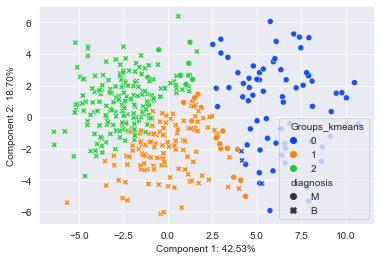

In [122]:
# adding column with group number
components['Groups_kmeans'] = groups_kmeans

# wykres pierwszych dwóch głównych składowych
sns.scatterplot(x='Component 1', y='Component 2', data=components,
                hue='Groups_kmeans',
                style='diagnosis',
                edgecolors = 'b',
                palette='bright',
                alpha=0.9)
plt.xlabel('Component 1: 42.53%')
plt.ylabel('Component 2: 18.70%')
plt.show()

In [113]:
# adding column with group number
data['Groups_kmeans'] = groups_kmeans

# pivot table with groups by clustering and cancer type
data_pivot_kmeans = data.pivot_table(index='Groups_kmeans', columns='diagnosis', values='area_mean',
                 aggfunc=lambda x: len(x), margins=True)
data_pivot_kmeans.fillna(0, inplace=True)

# adding column with part of benign cancer in each group
data_pivot_kmeans['B_part'] = round(
    data_pivot_kmeans.loc[:, "B"]/data_pivot_kmeans.loc[:, "All"], 2)

# adding column with part of malignant cancer in each group
data_pivot_kmeans['M_part'] = round(
    data_pivot_kmeans.loc[:, "M"]/data_pivot_kmeans.loc[:, "All"], 2)

data_pivot_kmeans


diagnosis,B,M,All,B_part,M_part
Groups_kmeans,,,,,
0,3,69,72,0.04,0.96
1,113,19,132,0.86,0.14
2,184,10,194,0.95,0.05
All,300,98,398,0.75,0.25


The graph and the table show that symptoms of two groups mean a specific cancer type. The error is about 5%. We also can see the group where similar symptoms mean malignant cancer only in 14% of cases.

In [114]:
# average values by groups
data_std_by_kmeans_group = data_std.groupby(
    'Groups_kmeans').mean(numeric_only=True).iloc[:, :-1]

data_std_by_kmeans_group

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
Groups_kmeans,,,,,,,,,,,,,,,,,,,,,
0,1.511907,0.606249,1.550054,1.574012,0.647296,1.219243,1.585984,1.698097,0.609429,-0.117058,...,1.631535,0.632802,1.653342,1.690376,0.754450,1.093880,1.288989,1.466095,0.654310,0.502566
1,-0.389266,0.000046,-0.352800,-0.403832,0.379936,0.427305,0.112757,-0.024559,0.216792,0.693422,...,-0.385045,-0.021613,-0.325489,-0.402332,0.282844,0.399907,0.245668,0.119700,0.087213,0.598001
2,-0.296259,-0.225031,-0.335228,-0.309397,-0.498747,-0.743246,-0.665334,-0.613512,-0.373687,-0.428369,...,-0.343529,-0.220149,-0.392145,-0.353605,-0.472453,-0.678077,-0.645544,-0.625563,-0.302178,-0.593407


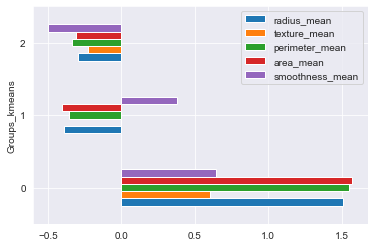

In [115]:
# average values of groups by 5 choosen variables
data_std_by_kmeans_group.iloc[:,:5].plot.barh()
plt.show()


The graph above shows characteristics of the created groups according to the firts 5 variables.

## <font color = lightgreen size = 6>**Hierarchical and k-means methods comparison**</font>

In [116]:
# pivot table with groups by both clustering method
data_pivot_groups = data_std.pivot_table(index='Groups_hier', columns='Groups_kmeans', values='area_mean',
                                         aggfunc=lambda x: len(x), margins=True)
data_pivot_groups.fillna(0, inplace=True)
print(data_pivot_groups)

# correlation score
chi2 = chi2_contingency(data_pivot_groups)[0]
c_pearson = np.sqrt(chi2/(chi2+len(data_std['Groups_kmeans'])))

print(f'Correlation score: {c_pearson}')

Groups_kmeans     0      1      2  All
Groups_hier                           
0              16.0   30.0   12.0   58
1              23.0    9.0    0.0   32
2               0.0   57.0   80.0  137
3              33.0    0.0    0.0   33
4               0.0    0.0  102.0  102
5               0.0   36.0    0.0   36
All            72.0  132.0  194.0  398
Correlation score: 0.7264956006002925


The correlation score shows that the groups created are quite similar.<br>
In both cases we received groups with symptoms, which quite clear identify type of cancer. In the hierachical method the groups with the benign cancer symptoms have numbers 2, 4 and 5 and the group with the malignant cancer symptoms has numer 3. In the k-Means metod the group nr 2 means benign cancer and the group nr 0 means malignant cancer.<br>
There are also groups which despite similar symptoms have the different type of cancer, nr 0 i nr 1 in the hierachical method and nr 1 in the k-Means method.

## <font color = lightgreen size = 6>**Clustering conclusion**</font>

The groups formed by clustering are quite similar to the cancer type groups. Clustering has identified symptomatic groups where both types of cancer may be present. The type of cancer with such symptoms have to be recognized only by a doctor, because algorithms are not able to clearly determine it.<br>
Using the characteristics of such groups from hierarchical clustering, the number of these cases will be much smaller.

Creation of a table with the characteristics of atypical symptoms of the cancer, where the type should be recognized only by a doctor.

In [117]:
# average values for group nr 0 by hierarchical clustering
group_0_avg = data.groupby(
    'Groups_hier').mean(numeric_only=True).iloc[:1,:-1].T

# standard deviation values for group nr 0 by hierarchical clusterings
group_0_std = data.groupby(
    'Groups_hier').std().iloc[:1, :-1].T

# lower and upper limit of each variable
group_0_lower = group_0_avg - group_0_std
group_0_upper = group_0_avg + group_0_std


In [118]:
# average values for group nr 1 by hierarchical clusterings
group_1_avg = data.groupby(
    'Groups_hier').mean(numeric_only=True).iloc[1:2, :-1].T

# standard deviation values for group nr 1 by hierarchical clusterings
group_1_std = data.groupby(
    'Groups_hier').std().iloc[1:2, :-1].T

# lower and upper limit of each variable
group_1_lower = group_1_avg - group_1_std
group_1_upper = group_1_avg + group_1_std

In [119]:
# creating the table with that characteristics
untypical_gr_char = pd.concat(
    [group_0_lower, group_0_upper, group_1_lower, group_1_upper], join='inner', axis=1)
untypical_gr_char.columns = ['Group_0_lower_lim',
                             'Group_0_upper_lim', 'Group_1_lower_lim', 'Group_1_upper_lim']

untypical_gr_char.head()

,Group_0_lower_lim,Group_0_upper_lim,Group_1_lower_lim,Group_1_upper_lim
radius_mean,13.651837,16.914025,13.339825,15.875175
texture_mean,15.631954,23.120115,16.337580,23.236170
perimeter_mean,88.678854,109.875974,87.602551,105.581824
area_mean,572.167082,889.719125,544.853536,774.533964
smoothness_mean,0.084911,0.102779,0.101263,0.116176


# <font color = limegreen size = 7>**Summary**</font>

The symptoms of benign cancer and malignant cancer are noticeably different, but there is no clear line that separates them. There are groups of cancers that, despite similar symptoms, have a different type.<br>
Due to clustering these groups were defined. In the subsequent analysis, cancer with the characteristics of these groups can be rejected, since their diagnosis requires only a doctor.